In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Activation,Conv2D,Dense,MaxPool2D,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.applications import VGG16

In [2]:
train_dir = '../input/firedata/Training/Training'
test_dir = '../input/firedata/Test/Test'

In [3]:
train_images = ImageDataGenerator(rescale=1.0/255,
                                 zoom_range=0.1,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 validation_split=0.2)

train_generator = train_images.flow_from_directory(train_dir,
                                                    target_size=(254,254), 
                                                    color_mode='rgb', 
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    batch_size=64,
                                                    subset='training')

validation_generator = train_images.flow_from_directory(train_dir, 
                                                        target_size=(254,254),
                                                        color_mode='rgb',
                                                        class_mode='binary',
                                                        batch_size=64,
                                                        shuffle=True,
                                                        subset='validation')

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.


In [4]:
test_images = ImageDataGenerator(rescale=1.0/255)

test_generator = test_images.flow_from_directory(test_dir,
                                                    target_size=(254,254), 
                                                    color_mode='rgb', 
                                                    class_mode='binary',
                                                    shuffle=False,
                                                    batch_size=64)

Found 8617 images belonging to 2 classes.


In [5]:
input_shape = (254,254,3)
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 252, 252, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       7

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import datetime
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from IPython.display import Image, display

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples  // 64,
                    epochs=50,
                    validation_data = validation_generator, 
                    validation_steps = validation_generator.samples // 64,
                    callbacks=[es, rlr, mcp, tb],
                    verbose=1
    )
model.save('./SimpleConv.h5')

Epoch 1/50
492/492 [==============================] - 892s 2s/step - loss: 0.9223 - accuracy: 0.7960 - val_loss: 0.0691 - val_accuracy: 0.9743

Epoch 00001: val_loss improved from inf to 0.06915, saving model to weights.h5
Epoch 2/50
492/492 [==============================] - 594s 1s/step - loss: 0.1872 - accuracy: 0.9344 - val_loss: 0.0797 - val_accuracy: 0.9755

Epoch 00002: val_loss did not improve from 0.06915
Epoch 3/50
492/492 [==============================] - 594s 1s/step - loss: 0.1454 - accuracy: 0.9499 - val_loss: 0.1569 - val_accuracy: 0.9369

Epoch 00003: val_loss did not improve from 0.06915
Epoch 4/50
492/492 [==============================] - 598s 1s/step - loss: 0.1654 - accuracy: 0.9511 - val_loss: 0.1031 - val_accuracy: 0.9597

Epoch 00004: val_loss did not improve from 0.06915
Epoch 5/50
492/492 [==============================] - 599s 1s/step - loss: 0.1298 - accuracy: 0.9596 - val_loss: 0.0548 - val_accuracy: 0.9727

Epoch 00005: val_loss improved from 0.06915 to 0

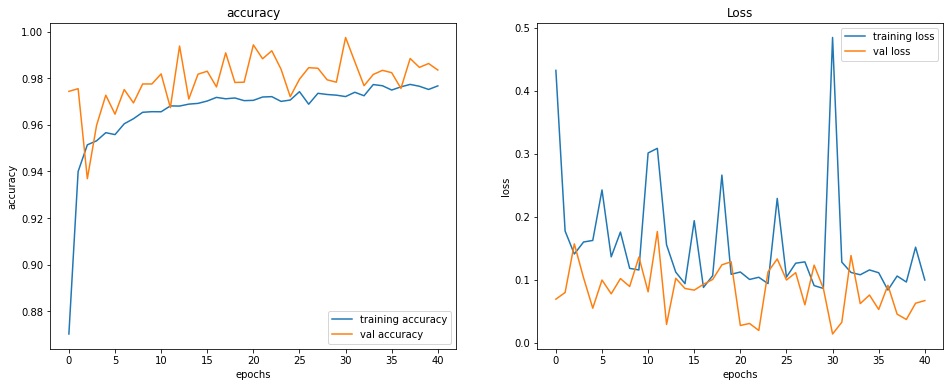

In [7]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [8]:
saved_model = load_model('./SimpleConv.h5')
saved_model.evaluate(test_generator)

135/135 [==============================] - 97s 718ms/step - loss: 1.2353 - accuracy: 0.7349


[1.2353204488754272, 0.7349425554275513]

In [9]:
# VGG16

In [10]:
from keras.models import Model
from glob import glob
# re-size all the images to this
IMAGE_SIZE = [224, 224]


# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False
  

  
  # useful for getting number of classes

#folders = glob('../input/firedata/Training/Training/*')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(2, activation='sigmoid')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [11]:
train_images = ImageDataGenerator(rescale=1.0/255,
                                 zoom_range=0.1,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 validation_split=0.2)

train_generator = train_images.flow_from_directory(train_dir,
                                                    #target_size=(254,254), 
                                                    color_mode='rgb', 
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    subset='training')

validation_generator = train_images.flow_from_directory(train_dir, 
                                                        #target_size=(254,254),
                                                        color_mode='rgb',
                                                        class_mode='binary',
                                                        shuffle=True,
                                                        subset='validation')

test_images = ImageDataGenerator(rescale=1.0/255)

test_generator = test_images.flow_from_directory(test_dir,
                                                    #target_size=(254,254), 
                                                    color_mode='rgb', 
                                                    class_mode='binary',
                                                    shuffle=False)
                                                    #batch_size=64)

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [12]:
#fit the model
r = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=5
)


# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf

from keras.models import load_model

model.save('vgg.h5')


Epoch 1/5


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:174 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))
